In [1]:
import InputGenerator
import base_model
import keras
import pandas as pd
import numpy as np
import baseline_model
import importlib
import setGPU

Using TensorFlow backend.


setGPU: Setting GPU to: 0


/usr/local/lib64/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
import InputBatchGenerator

<module 'baseline_model' from '/nfshome/llayer/AIErrorLogAnalysis/training/baseline_model.py'>

In [44]:
importlib.reload(InputGenerator)

<module 'InputGenerator' from '/nfshome/llayer/AIErrorLogAnalysis/training/InputGenerator.py'>

In [104]:
importlib.reload(InputBatchGenerator)

<module 'InputBatchGenerator' from '/nfshome/llayer/AIErrorLogAnalysis/training/InputBatchGenerator.py'>

In [3]:
gen = InputGenerator.InputGenerator('/nfshome/llayer/data/actionshistory.json')

In [4]:
gen.set_padded_tokens()

In [5]:
gen.get_input_shape()

(25090, 64, 151, 200)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

In [154]:
import nlp_model

In [161]:
importlib.reload(nlp_model)

<module 'nlp_model' from '/nfshome/llayer/AIErrorLogAnalysis/training/nlp_model.py'>

ImportError: cannot import name 'NLP_Model'

In [204]:
importlib.reload(base_model)
importlib.reload(baseline_model)
importlib.reload(nlp_model) 

class FitHandler(object):
    
    def __init__(self, gen):
        
        self.gen = gen
        self.dim_tasks, self.dim_errors, self.dim_sites, self.dim_msg = gen.get_input_shape()
        self.sites = gen.sites
        self.codes = gen.codes
    
    def split_frame(self, label, split_level):
        
        train, test, _, _ = train_test_split(gen.actionshistory, gen.actionshistory[label], test_size=split_level)
        return train, test
        
    def k_fold_indices(self, kfold_function=KFold, kfold_splits=5, verbose=0):
        
        enum = enumerate(kfold_function(n_splits=kfold_splits, shuffle=True, random_state=seed).split(X,Y))
        if verbose != 0:
            enum = tqdm(enum, total=kfold_splits, desc='kfold', leave=False, initial=0)
        return enum
        
    def fit_base_model(self, label, batch_size = 100, test_split=0.2, val_split=0.2, verbose=0):
        
        
        # Split in train and test frames
        train, test = self.split_frame(label, test_split)
        
        # Setup the generator of the input batches
        train_gen = InputBatchGenerator.InputBatchGenerator(train, label, \
                                                            batch_size, self.codes, self.sites, self.dim_msg)
        test_gen = InputBatchGenerator.InputBatchGenerator(test, label, \
                                                            batch_size, self.codes, self.sites, self.dim_msg)        
        X_train, y_train = train_gen.count_matrix()
        X_test, y_test = test_gen.count_matrix()
        
        print(X_train.shape)
        print(X_test.shape)
        
        # Set the baseline model
        model = baseline_model.FF(2, self.dim_errors, self.dim_sites)
        
        """
        history = model.train(X_train, y_train, X_test, y_test, max_epochs = 200, batch_size = 100, early_stopping = True)
        
        return history
        """
        
        model.find_optimal_parameters(X_train, y_train, X_test, y_test, max_epochs = 200, batch_size = 100, num_calls=12)

        
    def fit_nlp_model(self):

        # Set the baseline model
        model = nlp_model.NLP_Model(2, self.dim_errors, self.dim_sites, self.dim_msg)            
        model.print_summary()
        
        

In [205]:
handler = FitHandler(gen)

In [206]:
handler.fit_nlp_model()

Word encoder model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_85 (InputLayer)        (None, 200)               0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 200, 50)           2868400   
_________________________________________________________________
lstm_12 (LSTM)               (None, 10)                2440      
Total params: 2,870,840
Trainable params: 2,440
Non-trainable params: 2,868,400
_________________________________________________________________


Site encoder model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_86 (InputLayer)        (None, 64, 12)            0         
_________________________________________________________________
flatten_67 (Flatten)         (None, 768)               0         
_____________________

In [137]:
history = handler.fit_base_model('action_binary_encoded', verbose=1)

(20072, 64, 151, 2)
(5018, 64, 151, 2)

 	 ::: 1 SKOPT CALL ::: 

{'dense_layers': 3, 'dense_units': 50, 'regulizer_value': 0.0015, 'dropout_value': 0.015, 'learning_rate': 0.001}
Set early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        (None, 64, 151, 2)        0         
_________________________________________________________________
flatten_51 (Flatten)         (None, 19328)             0         
_________________________________________________________________
dense_375 (Dense)            (None, 50)                966450    
_________________________________________________________________
dropout_325 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_376 (Dense)            (None, 50)                2550      
_________________________________________________________________
dropout_3

Train on 20072 samples, validate on 5018 samples
Epoch 1/200
20072/20072 [==============================] - 13s 638us/step - loss: 16.2009 - val_loss: 15.0451
Epoch 2/200
20072/20072 [==============================] - 4s 177us/step - loss: 14.2880 - val_loss: 13.6084
Epoch 3/200
20072/20072 [==============================] - 3s 172us/step - loss: 12.9366 - val_loss: 12.3275
Epoch 4/200
20072/20072 [==============================] - 4s 177us/step - loss: 11.7176 - val_loss: 11.1673
Epoch 5/200
20072/20072 [==============================] - 3s 164us/step - loss: 10.6118 - val_loss: 10.1134
Epoch 6/200
20072/20072 [==============================] - 3s 166us/step - loss: 9.6057 - val_loss: 9.1542
Epoch 7/200
20072/20072 [==============================] - 3s 164us/step - loss: 8.6895 - val_loss: 8.2782
Epoch 8/200
20072/20072 [==============================] - 3s 164us/step - loss: 7.8524 - val_loss: 7.4753
Epoch 9/200
20072/20072 [==============================] - 3s 170us/step - loss: 7.0

20072/20072 [==============================] - 3s 173us/step - loss: 0.1235 - val_loss: 0.1320
Epoch 77/200
20072/20072 [==============================] - 4s 174us/step - loss: 0.1231 - val_loss: 0.1316
Epoch 78/200
20072/20072 [==============================] - 3s 172us/step - loss: 0.1227 - val_loss: 0.1313
Epoch 79/200
20072/20072 [==============================] - 3s 173us/step - loss: 0.1223 - val_loss: 0.1310
Epoch 80/200
20072/20072 [==============================] - 3s 174us/step - loss: 0.1221 - val_loss: 0.1307
Epoch 81/200
20072/20072 [==============================] - 3s 174us/step - loss: 0.1218 - val_loss: 0.1304
Epoch 82/200
20072/20072 [==============================] - 3s 173us/step - loss: 0.1215 - val_loss: 0.1301
Epoch 83/200
20072/20072 [==============================] - 3s 170us/step - loss: 0.1213 - val_loss: 0.1298
Epoch 84/200
20072/20072 [==============================] - 3s 171us/step - loss: 0.1210 - val_loss: 0.1296
Epoch 85/200
20072/20072 [===============

Epoch 6/200
20072/20072 [==============================] - 3s 164us/step - loss: 0.6856 - val_loss: 0.4395
Epoch 7/200
20072/20072 [==============================] - 3s 162us/step - loss: 0.3154 - val_loss: 0.2530
Epoch 8/200
20072/20072 [==============================] - 3s 163us/step - loss: 0.2107 - val_loss: 0.2009
Epoch 9/200
20072/20072 [==============================] - 3s 164us/step - loss: 0.1802 - val_loss: 0.1838
Epoch 10/200
20072/20072 [==============================] - 3s 163us/step - loss: 0.1688 - val_loss: 0.1752
Epoch 11/200
20072/20072 [==============================] - 3s 163us/step - loss: 0.1619 - val_loss: 0.1691
Epoch 12/200
20072/20072 [==============================] - 3s 164us/step - loss: 0.1566 - val_loss: 0.1639
Epoch 13/200
20072/20072 [==============================] - 3s 162us/step - loss: 0.1520 - val_loss: 0.1596
Epoch 14/200
20072/20072 [==============================] - 3s 161us/step - loss: 0.1481 - val_loss: 0.1558
Epoch 15/200
20072/20072 [======

KeyboardInterrupt: 

In [70]:
history.keys()

dict_keys(['val_loss', 'loss', 'predictions', 'labels', 'val_predictions', 'val_labels'])

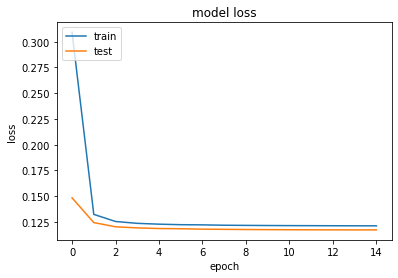

In [73]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
        
##############
# Functions to yield batches for the training
##############


def train_generator(self, batch_size):

    train_gen = InputBatchGenerator(self.X_train, self.y_train, batch_size, self.codes, self.sites, self.dim_msg)

    while True:
        try:
            for B in train_gen.generate_msg_count_batches():
                yield B
        except StopIteration:
            logging.warning("start over generator loop")          

def test_generator(self, batch_size):

    test_gen = InputBatchGenerator(self.X_test, self.y_test, batch_size, self.codes, self.sites, self.dim_msg)
    for B in test_gen.generate_msg_count_batches():
        yield B